In [1]:
import sys
sys.path.append('/home/mayalaidler/seticore/python/')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import capnp
import viewer 
import pandas as pd
import seaborn as sns
import re

fn03 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.hits'


kj/filesystem-disk-unix.c++:1734: warning: PWD environment variable doesn't match current directory; pwd = /mnt_home/mayalaidler


In [2]:
#Make the pandas dataframe
hit_capnp = capnp.load('/mnt_home/mayalaidler/seticore/hit.capnp')

# Define a function to read the .hits file
def read_hits(filename):
    with open(filename, 'rb') as f:
        hits = hit_capnp.Hit.read_multiple(f)
        data = [hit.to_dict()['filterbank'] for hit in hits]
        f.seek(0,0)
        hits = hit_capnp.Hit.read_multiple(f)
        data2 = [hit.to_dict()['signal'] for hit in hits]
        d = pd.DataFrame(data)
        d2 = pd.DataFrame(data2)
        d3 = pd.concat([d, d2], axis = 1, join = 'outer')
    return d3

# Load the .hits file as a pandas DataFrame
df3 = read_hits(fn03)
highSNR = np.where(df3['snr'] > 11000)[0]

idx = highSNR[0]
print(idx)
start_channel = (df3['startChannel'].iloc[idx])
num_channels = (df3['numChannels'].iloc[idx]) 
foff = df3['foff'].iloc[idx]
fch1 = (df3['fch1'].iloc[idx])

beam00 = read_hits('/home/mayalaidler/seticore.output/band01.beam00.hits')


def find_main_carrier_frequency(data):
    power_spectrum = np.sum(data, axis=0)
    main_carrier_idx = np.argmax(power_spectrum)
    return main_carrier_idx

467


In [3]:
#Load h5 file
def load_h5(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        data = h5_file["data"][()]
        # Assuming the data has a shape of (time, beam, frequency)
        data = data[:, 0, :]  # Remove the middle dimension if it has a size of 1
        return data

def combine_channels(data, factor=512):
    if data.shape[1] % factor != 0:
        raise ValueError("Number of channels must be divisible by the factor.")
    return data.reshape(data.shape[0], data.shape[1] // factor, factor).sum(axis=2)

In [4]:
hitsDirectory = '/home/mayalaidler/breakthrough/outputFiles'
mergedNormalizedpd = pd.DataFrame()  # inner, outer, left, right


# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Initialize a list to store DataFrames
dataframes = []

for file_name in os.listdir(hitsDirectory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(hitsDirectory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            
            beam_pattern = re.compile(r'beam(\d+)')
            match = beam_pattern.search(file_name)
            if match:
                beam_number = int(match.group(1))
            else:
                print(f"No beam number found in file name: {file_name}")
                continue
            
            data = read_hits(file_path)
            data['beam'] = beam_number
            
            # Append DataFrame to the list
            dataframes.append(data)
            mergedNormalizedpd = pd.concat(dataframes, ignore_index=True)

In [5]:

# print(df3.dtypes)
# print(mergedNormalizedpd.dtypes)

# # df3['frequency'] = df3['frequency'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# # df3['snr'] = df3['snr'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# # mergedNormalizedpd['frequency'] = mergedNormalizedpd['frequency'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# # mergedNormalizedpd['snr'] = mergedNormalizedpd['snr'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# df_all = df3.merge(mergedNormalizedpd.drop_duplicates(), on=['frequency', 'snr'], how='left', indicator=True)

# #create DataFrame with rows that exist in first DataFrame only
# df1_only = df_all[df_all['_merge'] == 'left_only']


dfUnnorm = df3
dfNorm = mergedNormalizedpd

hits_dfNorm = set(dfNorm[['frequency', 'beam']].itertuples(index=False, name=None))
hits_dfUnnorm = set(dfUnnorm[['frequency', 'beam']].itertuples(index=False, name=None))

# Hits in Norm but not in Unnorm
missing_hits = hits_dfNorm - hits_dfUnnorm

# Hits in Unnorm but not in Norm 

missing_hits2 = hits_dfUnnorm - hits_dfNorm

# Convert missing_hits to a DataFrame for plotting

merged_df = dfNorm[dfNorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits)]
merged_df2 = dfNorm[dfNorm[['frequency', 'beam']].apply(tuple, axis=1).isin(missing_hits2)]

print('l', merged_df)
print('v', merged_df2)
# missing_hits_df = pd.DataFrame(list(missing_hits), columns=dfNorm.columns)

l                    sourceName         fch1      foff        tstart     tsamp  \
215  Gaia_4060289836270794752  2270.335213  0.000002  60450.067839  4.908534   
216  Gaia_4060289836270794752  2270.351213  0.000002  60450.067839  4.908534   
217  Gaia_4060289836270794752  2270.367213  0.000002  60450.067839  4.908534   
218  Gaia_4060289836270794752  2270.383213  0.000002  60450.067839  4.908534   
219  Gaia_4060289836270794752  2270.399213  0.000002  60450.067839  4.908534   
220  Gaia_4060289836270794752  2270.407215  0.000002  60450.067839  4.908534   
221  Gaia_4060289836270794752  2270.415212  0.000002  60450.067839  4.908534   
222  Gaia_4060289836270794752  2270.431214  0.000002  60450.067839  4.908534   
223  Gaia_4060289836270794752  2270.447214  0.000002  60450.067839  4.908534   
224  Gaia_4060289836270794752  2270.463214  0.000002  60450.067839  4.908534   
225  Gaia_4060289836270794752  2270.479214  0.000002  60450.067839  4.908534   
256  Gaia_4058793504024683904  2270.33

['0']
ssss
['40']
['6']
['7']
['8']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


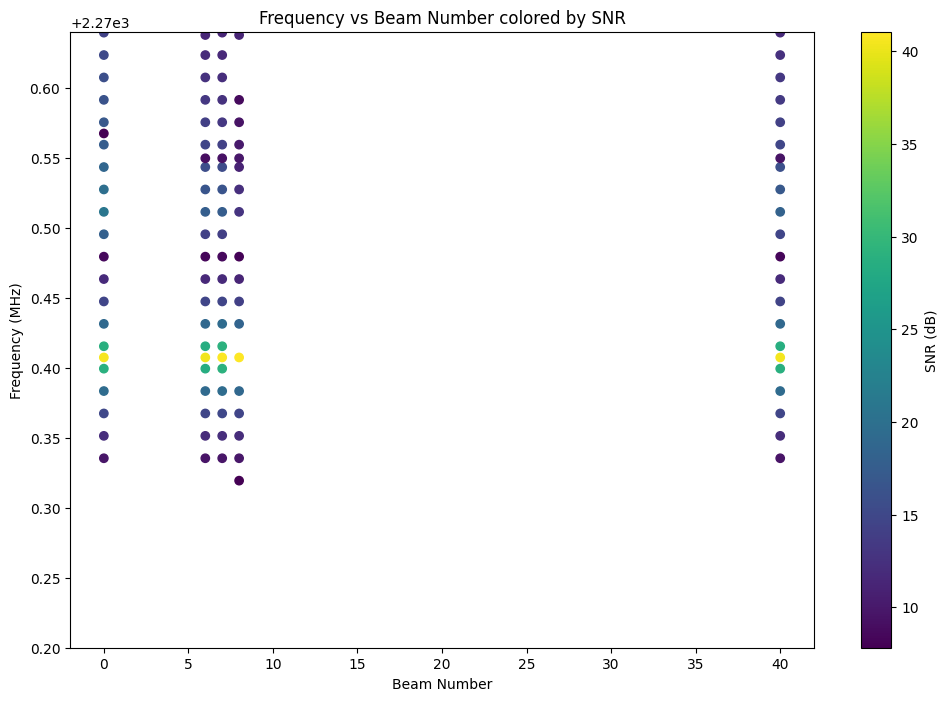

In [6]:
directory = '/home/mayalaidler/breakthrough/hitsFiles'

# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Lists to hold the data for plotting
beam_numbers2 = []
frequencies2 = []
snr_values2 = []
beam0snr = []
beam0freq = []

for file_name in os.listdir(directory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(directory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            data = read_hits(file_path)
            
            # Load in snr and freq values
            file_snr_values = data['snr']
            file_frequencies = data['frequency']
            
            # Normalize the SNR values
            file_snr_values = 10*np.log10(file_snr_values)
            
            # Extract beam number
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                beam_number = 'inco'
            elif numbers:
                beam_number = int(numbers[0])
                print(numbers)
                if int(numbers[0]) == 0:
                    print('ssss')
                    beam0snr.extend(file_snr_values)
                    beam0freq.extend(file_frequencies)
        
            else:
                beam_number = 0
            
            # Append the data to the lists
            beam_numbers2.extend([beam_number] * len(file_frequencies))
            frequencies2.extend(file_frequencies)
            snr_values2.extend(file_snr_values)

# Create the scatter plot
scatter = plt.scatter(beam_numbers2, frequencies2, c=snr_values2, cmap='viridis')
plt.ylim(2270.2, 2270.64)
print(beam_numbers2)

plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(scatter, label='SNR (dB)')
plt.title('Frequency vs Beam Number colored by SNR')
plt.show()

0       39.892941
1        6.274513
2       49.669636
3       11.242610
4        6.736231
          ...    
1944    26.267887
1945    10.511921
1946    27.052530
1947    10.012634
1948    26.563660
Name: snr, Length: 1949, dtype: float64


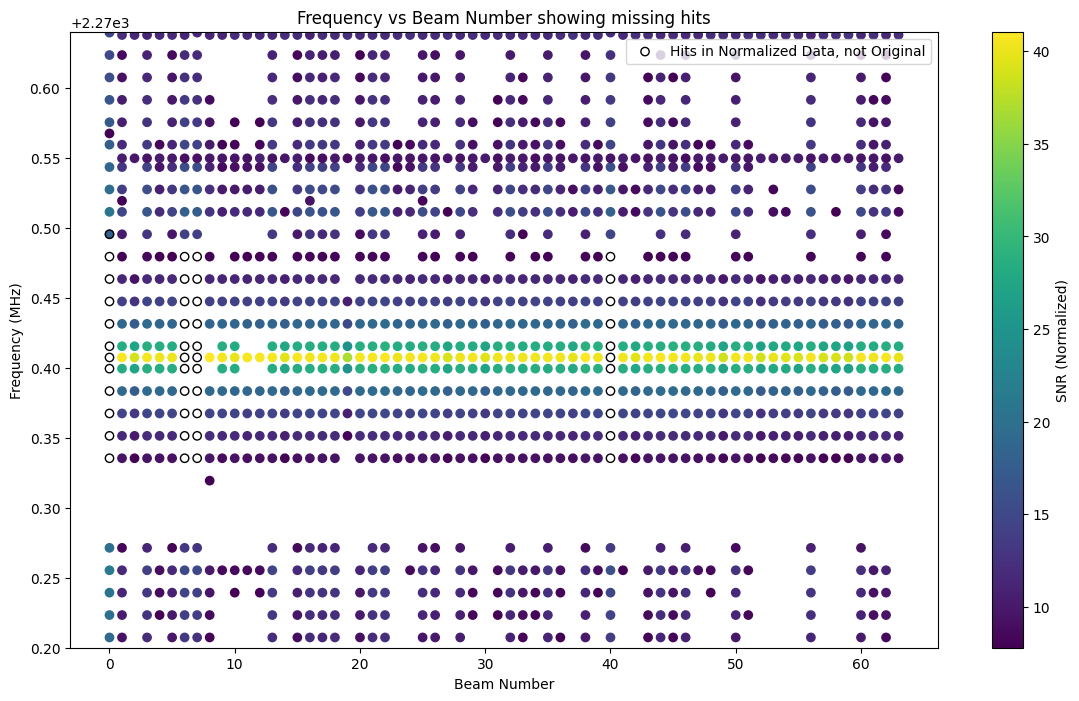

In [7]:
plt.figure(figsize= (14, 8))

freq = df3['frequency']
snr_values = df3['snr']
print(snr_values)
snr_values = 10*np.log10(snr_values)
beam = df3['beam']
first_beam = beam.iloc[:, 0]   
         
plt.scatter(first_beam, freq, c=(snr_values), cmap='viridis')
plt.colorbar(label='SNR (Normalized)')

freq = merged_df['frequency']
beam = merged_df['beam']
first_beam = beam.iloc[:, 0]   
         
plt.scatter(first_beam, freq, edgecolor='black', facecolor='none', marker='o', label='Hits in Normalized Data, not Original')

plt.scatter([0]*12, frequencies2[:12], edgecolors= 'black', facecolor= 'none')

plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.title('Frequency vs Beam Number showing missing hits')
plt.ylim(2270.2, 2270.64)
plt.legend(frameon=True, title_fontsize='large')
plt.show()

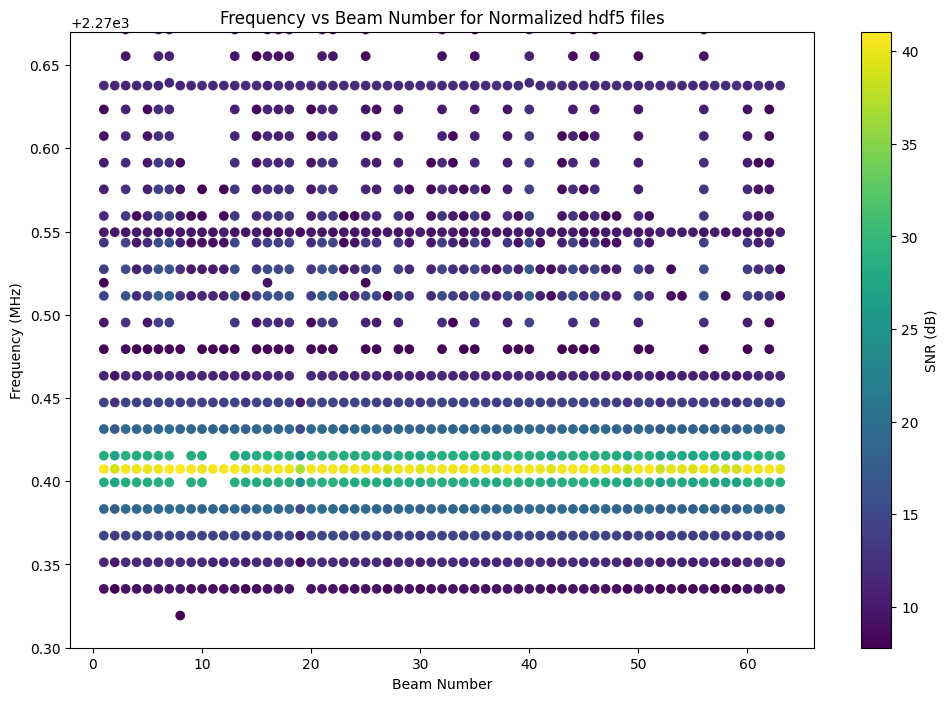

41.05742504763018 2270.40733397007


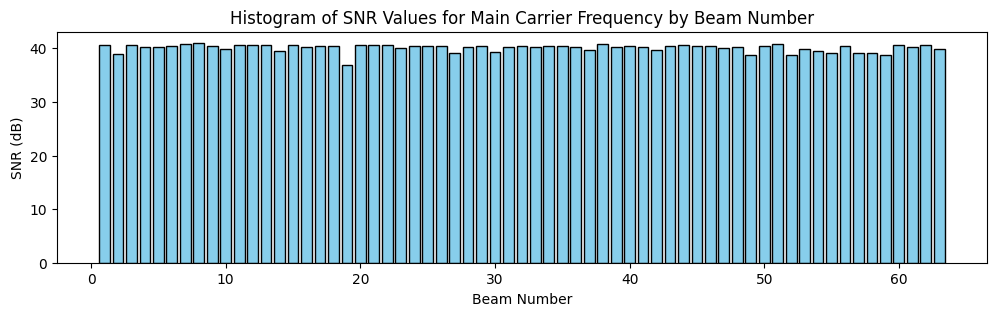

In [8]:
hitsDirectory = '/home/mayalaidler/breakthrough/outputFiles'
mergedNormalizedpd = pd.DataFrame()  # inner, outer, left, right


# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Lists to hold the data for plotting
beam_numbers = []
frequencies = []
snr_values = []
snr_values2 = []
beam_numbers2 =[]

main_carrier = 0

# Initialize a list to store DataFrames
dataframes = []
main_carrier_freq = -1

for file_name in os.listdir(hitsDirectory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(hitsDirectory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            
            beam_pattern = re.compile(r'beam(\d+)')
            match = beam_pattern.search(file_name)
            if match:
                beam_number = int(match.group(1))
            else:
                print(f"No beam number found in file name: {file_name}")
                continue
            
            data = read_hits(file_path)
            main_carrier_freq = find_main_carrier_frequency(data['data'])
            data['beam'] = beam_number
            
            # Append DataFrame to the list
            dataframes.append(data)
            mergedNormalizedpd = pd.concat(dataframes, ignore_index=True)
            
            # Load in snr and freq values
            file_snr_values = data['snr']
            file_frequencies = data['frequency']
            
            # Normalize the SNR values
            file_snr_values = 10*np.log10(file_snr_values)
            
            # Extract beam number
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                beam_number = 'inco'
            elif numbers:
                beam_number = int(numbers[-1])
            else:
                beam_number = 0
            
            # Append the data to the lists
            # Filter for the main carrier frequency
            main_carrier_snr = file_snr_values.iloc[main_carrier]
            main_carrier_freq = file_frequencies.iloc[main_carrier]
            
            # Append the data to the lists
            beam_numbers2.append(beam_number)
            snr_values2.append(main_carrier_snr)

            beam_numbers.extend([beam_number] * len(file_frequencies))
            frequencies.extend(file_frequencies)
            snr_values.extend(file_snr_values)

# Create the scatter plot
# print("len", len(beam_numbers), len(frequencies))
# print(beam_numbers[:10], frequencies[:10])
scatter = plt.scatter(beam_numbers, frequencies, c=snr_values, cmap='viridis')
plt.ylim(2270.3, 2270.67)
plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(scatter, label='SNR (dB)')
plt.title('Frequency vs Beam Number for Normalized hdf5 files')
plt.show()

# Create the histogram
plt.figure(figsize=(12, 3))

# print(main_carrier_freq, max(snr_values))
max_snr = max(snr_values)
max_snr_freq = -1
for i in range(len(frequencies)):
    if snr_values[i] == max_snr:
        max_snr_freq = frequencies[i]
print(max_snr, max_snr_freq)

filtered_beams = []
filtered_snr = []
for i in range(len(beam_numbers)):
    if round(frequencies[i], 3) == round(max_snr_freq, 3):
        filtered_snr.append(snr_values[i])
        filtered_beams.append(beam_numbers[i])


plt.bar(filtered_beams, filtered_snr, color='skyblue', edgecolor='black')
plt.xlabel('Beam Number')
plt.ylabel('SNR (dB)')
plt.title('Histogram of SNR Values for Main Carrier Frequency by Beam Number')
plt.show()
